In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
from optuna.exceptions import ExperimentalWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ExperimentalWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
import numpy as np
import pandas as pd
import time

from pyspark.sql import SparkSession
from replay.utils.session_handler import get_spark_session, State

from replay.models import UCB, Wilson, RandomRec, LinUCB
from replay.experimental.scenarios.movielens_wrapper.replay_offline import OBPOfflinePolicyLearner
from replay.experimental.scenarios.movielens_wrapper.MIPS import MIPS
from replay.experimental.scenarios.movielens_wrapper.dataset import MovielensBanditDataset
from replay.experimental.scenarios.movielens_wrapper.utils import get_est_rewards_by_reg, bandit_subset

import obp
from obp.dataset import OpenBanditDataset
from obp.policy import IPWLearner
from obp.ope import (
    OffPolicyEvaluation,
    DirectMethod,
    InverseProbabilityWeighting,
    DoublyRobust,
    SelfNormalizedInverseProbabilityWeighting,
    SelfNormalizedDoublyRobust,
    MarginalizedInverseProbabilityWeighting,
)

'nlp' extra dependecy package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.


In [4]:
spark = State(get_spark_session()).session
spark.sparkContext.setLogLevel('ERROR')

24/09/10 21:30:27 WARN Utils: Your hostname, sudakovcom-MS-7D48 resolves to a loopback address: 127.0.1.1; using 10.255.173.26 instead (on interface enp3s0)
24/09/10 21:30:27 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/10 21:30:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/09/10 21:30:28 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


Lets define OpenBanditDataset class with random policy. For the purpose of demonstration we won't use the whole dataset but only subset of size 10000.

In [5]:
from rs_datasets import MovieLens

data = MovieLens("1m")
data.info()

ratings


,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968



users


,user_id,gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117



items


,item_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [6]:
dataset = MovielensBanditDataset(data)

10-Sep-24 21:30:29, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
10-Sep-24 21:30:35, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
10-Sep-24 21:30:36, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


fit started
predict started


100%|██████████| 1000209/1000209 [01:46<00:00, 9363.51it/s]


In [7]:
dataset.item_features.show(5)

+--------+-------+------+-----------+----------+-----+---------+---------+-----+---------+-------+------+-------+-------+--------+---+------+-------+------+
|item_idx|Mystery|Action|Documentary|Children's|Drama|Adventure|Film-Noir|Crime|Animation|Fantasy|Comedy|Western|Romance|Thriller|War|Sci-Fi|Musical|Horror|
+--------+-------+------+-----------+----------+-----+---------+---------+-----+---------+-------+------+-------+-------+--------+---+------+-------+------+
|      29|      0|     0|          0|         1|    0|        0|        0|    0|        1|      0|     1|      0|      0|       0|  0|     0|      0|     0|
|     393|      0|     0|          0|         1|    0|        1|        0|    0|        0|      1|     0|      0|      0|       0|  0|     0|      0|     0|
|     648|      0|     0|          0|         0|    0|        0|        0|    0|        0|      0|     1|      0|      1|       0|  0|     0|      0|     0|
|    1574|      0|     0|          0|         0|    1|    

In [8]:
dataset.user_features.show(5)

+--------+--------------+--------------+--------------+--------------+------------+--------+--------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+
|user_idx|agegroup_20-29|agegroup_30-39|agegroup_40-49|agegroup_51-60|agegroup_<20|gender_F|gender_M|occupation_0|occupation_1|occupation_2|occupation_3|occupation_4|occupation_5|occupation_6|occupation_7|occupation_8|occupation_9|occupation_10|occupation_11|occupation_12|occupation_13|occupation_14|occupation_15|occupation_16|occupation_17|occupation_18|occupation_19|occupation_20|
+--------+--------------+--------------+--------------+--------------+------------+--------+--------+------------+------------+------------+------------+------------+------------+------------+------------+------------+----------

In [9]:
dataset.log.show(5)

+--------+--------+---------+-------------------+
|user_idx|item_idx|relevance|          timestamp|
+--------+--------+---------+-------------------+
|    4131|      43|        1|2001-01-01 01:12:40|
|    4131|     585|        1|2001-01-01 01:35:09|
|    4131|     461|        1|2001-01-01 01:32:48|
|    4131|     105|        1|2001-01-01 01:04:35|
|    4131|      47|        1|2001-01-07 02:38:11|
+--------+--------+---------+-------------------+
only showing top 5 rows



In [10]:
dataset.context

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [11]:
dataset.action_context

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [12]:
bandit_feedback_train, bandit_feedback_test = dataset.obtain_batch_bandit_feedback(test_size=0.3, is_timeseries_split=True)

print(bandit_feedback_train["n_rounds"])
print(bandit_feedback_test["n_rounds"])

100%|██████████| 1113/1113 [00:00<00:00, 10518.67it/s]


700144
1113


In [13]:
bandit_feedback_train.keys()

dict_keys(['log', 'item_features', 'user_features', 'n_rounds', 'n_actions', 'action', 'position', 'reward', 'pscore', 'context', 'action_context'])

The keys of the dictionary are as follows.
- n_rounds: number of rounds, data size of the logged bandit data;
- n_actions: number of actions $|\mathcal{A}|$;
- action: action variables sampled by the behavior policy;
- position: positions where actions are recommended, there are three positions in the ZOZOTOWN rec interface;
- reward: binary reward variables, click indicators;
- pscore: action choice probabilities by the behavior policy, propensity scores;
- context: context vectors such as user-related features and user-item affinity scores;
- action_context: item-related context vectors

In [14]:
#Define replay model
model_1 = UCB(exploration_coef = 2.0, sample= True, seed= 123)
model_2 = LinUCB(eps = -10.0, alpha = 1.0, regr_type = 'disjoint')
model_3 = RandomRec(seed=42)

#Define learner which connects OBP data format with replay
learner_1 = OBPOfflinePolicyLearner(n_actions=dataset.n_actions,
                                    replay_model=model_1,
                                    len_list=dataset.len_list,) #len_list is the number of predicted items per user
learner_2 = OBPOfflinePolicyLearner(n_actions=dataset.n_actions,
                                    replay_model=model_2,
                                    len_list=dataset.len_list,) #len_list is the number of predicted items per user

learner_3 = OBPOfflinePolicyLearner(n_actions=dataset.n_actions,
                                    replay_model=model_3,
                                    len_list=dataset.len_list,)

**RePlayOfflinePolicyLearner** has the following methods
- *fit(action, reward, timestamp, context, action_context)*;
- *predict(n_rounds, context)* (context can be None thus n_rounds is **required**);
- *optimize(bandit_feedback, val_size, param_borders, criterion, budget, new_study)*

In [15]:
bandit_feedback_train['log'].show(3)

+--------+--------+---------+-------------------+
|user_idx|item_idx|relevance|          timestamp|
+--------+--------+---------+-------------------+
|    3021|     366|        1|2000-11-22 06:03:07|
|    3021|      37|        1|2000-11-22 06:03:36|
|    3021|       6|        1|2000-11-22 06:04:11|
+--------+--------+---------+-------------------+
only showing top 3 rows



In [16]:
#Fit replay model inside our learner
learner_1.fit(bandit_feedback_train)
learner_2.fit(bandit_feedback_train)
learner_3.fit(bandit_feedback_train)

In [17]:
estimated_rewards_by_reg_model = get_est_rewards_by_reg(dataset.n_actions,
                                                        dataset.len_list,
                                                        bandit_feedback_train,
                                                        bandit_feedback_test)

When we get distribution over actions - we can run any evaluation procedure from the OBP. Here we use three estimators
- *IPW*: Average rewards with importance weights
- *DM*: Average predicted rewards using the classifier
- *DR*: Combination of the above methods with zero bias and lower variance

Also, we can construct confidence intervals for each of these methods.

In [18]:
bandit_feedback_test['log'].show(100)

+--------+--------+---------+-------------------+
|user_idx|item_idx|relevance|          timestamp|
+--------+--------+---------+-------------------+
|    3021|     186|        1|2000-11-22 06:17:21|
|    2008|      18|        1|2000-11-22 06:12:29|
|    3773|    1860|        1|2000-11-22 06:18:50|
|     471|      73|        1|2001-03-22 06:04:35|
|    2207|      18|        1|2000-12-04 04:17:13|
|    3599|     172|        0|2000-11-22 06:26:16|
|    1310|     484|        1|2000-11-23 01:55:04|
|     492|    1569|        1|2000-11-22 07:25:15|
|     715|     471|        1|2000-11-23 21:04:59|
|    1304|     748|        1|2000-11-22 07:49:58|
|       4|     787|        1|2000-11-26 01:46:20|
|     706|    1631|        1|2000-11-22 21:23:40|
|    1517|    3060|        1|2000-12-20 08:47:12|
|     210|    1925|        1|2002-11-08 05:47:44|
|    2857|     471|        1|2000-11-23 05:48:57|
|    1746|     484|        1|2000-11-22 22:07:35|
|    3718|      18|        1|2000-11-26 06:20:52|


In [19]:
def get_dist(learner):
    all_action_dist = np.zeros((bandit_feedback_test["n_rounds"], dataset.n_actions, dataset.len_list))
    batch_size = 300
    num_batchs = bandit_feedback_test["n_rounds"] // batch_size
    for i in range(num_batchs+1):
        j = min((i+1)*batch_size, bandit_feedback_test["n_rounds"])
        bandit_feedback_subset = bandit_subset([i*batch_size, j], bandit_feedback_test) #The first parameter is a slice of subset [a, b]
        print(type(bandit_feedback_subset["log"].select('user_idx')))
        print(bandit_feedback_subset["log"].select('user_idx').count())
        action_dist = learner.predict(bandit_feedback_subset["n_rounds"], bandit_feedback_subset["log"].select('user_idx'))
        all_action_dist[i*batch_size:j, :, :] = action_dist
    return all_action_dist

In [20]:
#Predict distribution over actions: shape (n_rounds, n_actions, len_list)
import time
start = time.time()
learner_action_dist_1 = get_dist(learner_1)
print(time.time() - start)

start = time.time()
learner_action_dist_2 = get_dist(learner_2)
print(time.time() - start)

start = time.time()
learner_action_dist_3 = get_dist(learner_3)
print(time.time() - start)

<class 'pyspark.sql.dataframe.DataFrame'>
300


/home/sudakovcom/Desktop/RePlayHDILab2024/replay/models/base_rec.py:1515: SparkCollectToMasterWarning: Prediction with sampling performs spark to pandas convertion to master node, this may lead to OOM exception for large item catalogue.
  warnings.warn(


<class 'pyspark.sql.dataframe.DataFrame'>
300


/home/sudakovcom/Desktop/RePlayHDILab2024/replay/models/base_rec.py:1515: SparkCollectToMasterWarning: Prediction with sampling performs spark to pandas convertion to master node, this may lead to OOM exception for large item catalogue.
  warnings.warn(


<class 'pyspark.sql.dataframe.DataFrame'>
300


/home/sudakovcom/Desktop/RePlayHDILab2024/replay/models/base_rec.py:1515: SparkCollectToMasterWarning: Prediction with sampling performs spark to pandas convertion to master node, this may lead to OOM exception for large item catalogue.
  warnings.warn(


<class 'pyspark.sql.dataframe.DataFrame'>
213


/home/sudakovcom/Desktop/RePlayHDILab2024/replay/models/base_rec.py:1515: SparkCollectToMasterWarning: Prediction with sampling performs spark to pandas convertion to master node, this may lead to OOM exception for large item catalogue.
  warnings.warn(


1.0554769039154053
<class 'pyspark.sql.dataframe.DataFrame'>
300
+--------+--------+--------------------+--------------------+
|user_idx|item_idx|           relevance|       Softmax_Score|
+--------+--------+--------------------+--------------------+
|      46|      19|0.001496289994212363|0.046387328827325096|
|      46|      35|0.003830728409619...| 0.04649574368439647|
|      46|       5|0.025619097169291116| 0.04751992722033584|
|      46|      10| 0.00901025281104706| 0.04673719428321429|
|      46|      13|0.029788316521889735|  0.0477184618000592|
|      46|      28| 0.07499620809075291| 0.04992521842805477|
|      46|      14| 0.03557273444810549| 0.04799528518511868|
|      46|      30| 0.07733826078105599| 0.05004228295231987|
|      46|      12| 0.03797029894920234| 0.04811049503343125|
|      46|      11| 0.09733936714454083|0.051053260609386884|
|      46|      16| 0.07647140711742217| 0.04999892241234274|
|      46|       9|0.060609302455708836| 0.04921209116940509|
|    

/home/sudakovcom/Desktop/RePlayHDILab2024/replay/models/base_rec.py:1515: SparkCollectToMasterWarning: Prediction with sampling performs spark to pandas convertion to master node, this may lead to OOM exception for large item catalogue.
  warnings.warn(


<class 'pyspark.sql.dataframe.DataFrame'>
300


/home/sudakovcom/Desktop/RePlayHDILab2024/replay/models/base_rec.py:1515: SparkCollectToMasterWarning: Prediction with sampling performs spark to pandas convertion to master node, this may lead to OOM exception for large item catalogue.
  warnings.warn(


<class 'pyspark.sql.dataframe.DataFrame'>
300


/home/sudakovcom/Desktop/RePlayHDILab2024/replay/models/base_rec.py:1515: SparkCollectToMasterWarning: Prediction with sampling performs spark to pandas convertion to master node, this may lead to OOM exception for large item catalogue.
  warnings.warn(


<class 'pyspark.sql.dataframe.DataFrame'>
213
0.9433364868164062


/home/sudakovcom/Desktop/RePlayHDILab2024/replay/models/base_rec.py:1515: SparkCollectToMasterWarning: Prediction with sampling performs spark to pandas convertion to master node, this may lead to OOM exception for large item catalogue.
  warnings.warn(


In [21]:
def run_exp(learner_action_dist):
    Vs = []
    CIs = []

    # for n_size in [50000, 100000, 200000, 300000, bandit_feedback_test["n_rounds"]]:
    for n_size in [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, bandit_feedback_test["n_rounds"]]:
        start = time.time()
        bandit_feedback_subset = bandit_subset([0, n_size], bandit_feedback_test) #The first parameter is a slice of subset [a, b]

        ope = OffPolicyEvaluation(
            bandit_feedback=bandit_feedback_subset,
            ope_estimators=[InverseProbabilityWeighting(), DirectMethod(), SelfNormalizedDoublyRobust(),
                            SelfNormalizedInverseProbabilityWeighting(),]
        )

        estimated_rewards_by_reg_model_subset = estimated_rewards_by_reg_model[0: n_size, :, :]
        
        action_dist = learner_action_dist[:n_size, :, :]
        estimated_policy_value = ope.estimate_policy_values(
            action_dist=action_dist,
            estimated_rewards_by_reg_model=estimated_rewards_by_reg_model_subset,
        )

        estimated_ci = ope.estimate_intervals(
            action_dist=action_dist,
            estimated_rewards_by_reg_model=estimated_rewards_by_reg_model_subset,
            n_bootstrap_samples=10000,
            random_state=12345,)
        end = time.time()
        print("n_size =", n_size, "time: ", end-start)
        Vs.append(estimated_policy_value)
        CIs.append(estimated_ci)
    return(Vs, CIs)

In [22]:
Vs_1, CIs_1 = run_exp(learner_action_dist_1)

n_size = 100 time:  0.44722986221313477
n_size = 200 time:  0.4750354290008545
n_size = 300 time:  0.5577399730682373
n_size = 400 time:  0.5786361694335938
n_size = 500 time:  0.516848087310791
n_size = 600 time:  0.7614607810974121
n_size = 700 time:  0.716209888458252
n_size = 800 time:  0.6937642097473145
n_size = 900 time:  0.6706106662750244
n_size = 1000 time:  0.6267104148864746
n_size = 1113 time:  1.1128740310668945


In [23]:
Vs_2, CIs_2 = run_exp(learner_action_dist_2)

n_size = 100 time:  0.4187154769897461
n_size = 200 time:  0.4648740291595459
n_size = 300 time:  0.5700676441192627
n_size = 400 time:  0.5552105903625488
n_size = 500 time:  0.5191099643707275
n_size = 600 time:  0.7394328117370605
n_size = 700 time:  0.700108528137207
n_size = 800 time:  0.6868329048156738
n_size = 900 time:  0.6662735939025879
n_size = 1000 time:  0.664287805557251
n_size = 1113 time:  1.118957281112671


In [24]:
Vs_3, CIs_3 = run_exp(learner_action_dist_3)

n_size = 100 time:  0.4148859977722168
n_size = 200 time:  0.46024489402770996
n_size = 300 time:  0.565514087677002
n_size = 400 time:  0.551602840423584
n_size = 500 time:  0.5158827304840088
n_size = 600 time:  0.7405927181243896
n_size = 700 time:  0.7282431125640869
n_size = 800 time:  0.6939244270324707
n_size = 900 time:  0.6606216430664062
n_size = 1000 time:  0.6488029956817627
n_size = 1113 time:  1.118196725845337


In [25]:
import matplotlib.pyplot as plt
def plot_disjoint_res(Vs, CIs, model): 
    fig, ax = plt.subplots(4, figsize=(10, 10))

    # x = [50000, 100000, 200000, 300000, bandit_feedback_test["n_rounds"]]
    x = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, bandit_feedback_test["n_rounds"]]
    colors = ['b', 'r', 'g', 'y', 'k']
    i = 0
    for name in ['ipw', 'dm', 'sndr', 'snipw']:
        y_est = [estimated_ci[name]["mean"] for estimated_ci in CIs]
        y_up = [estimated_ci[name]["95.0% CI (upper)"] for estimated_ci in CIs]
        y_low = [estimated_ci[name]["95.0% CI (lower)"] for estimated_ci in CIs]

        ax[i].plot(x, y_est, '-', label=name, color = colors[i])
        ax[i].fill_between(x, y_low, y_up, alpha=0.2, color = colors[i])
        #ax.plot(x, y, 'o', color='tab:brown')
        i=i+1
    fig.suptitle("OPE for " + model, fontsize=16)
    fig.legend()

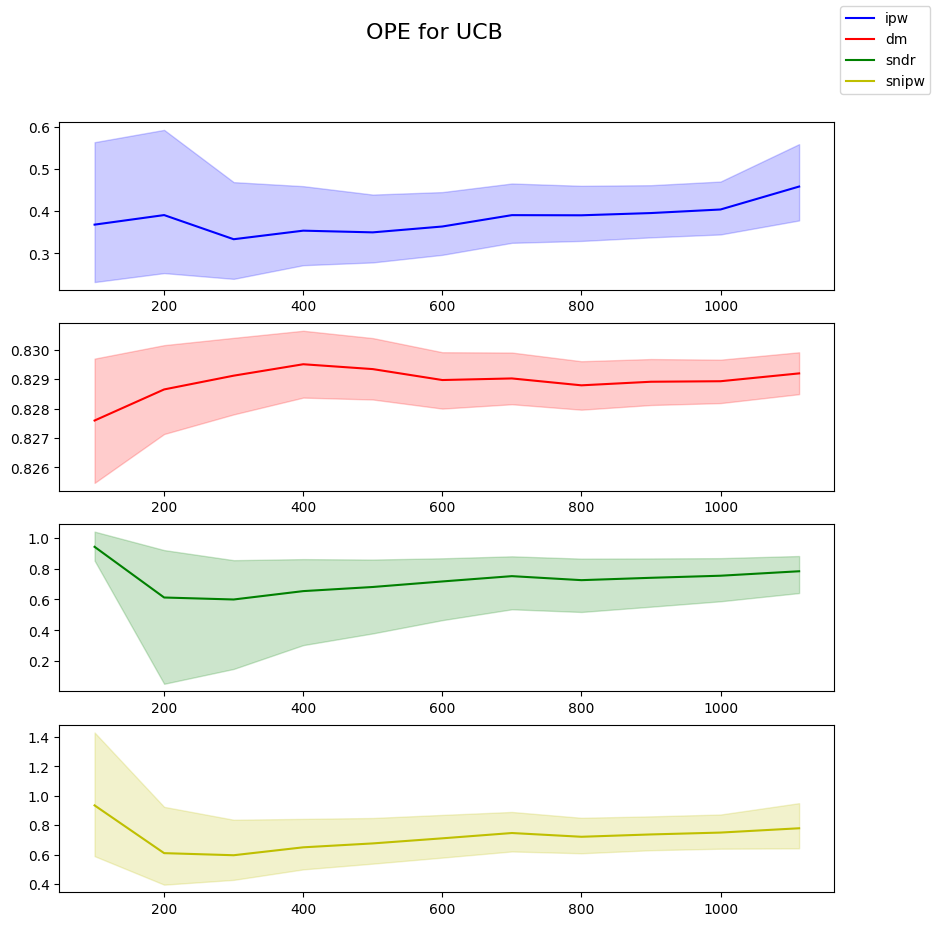

In [26]:
plot_disjoint_res(Vs_1, CIs_1, 'UCB')

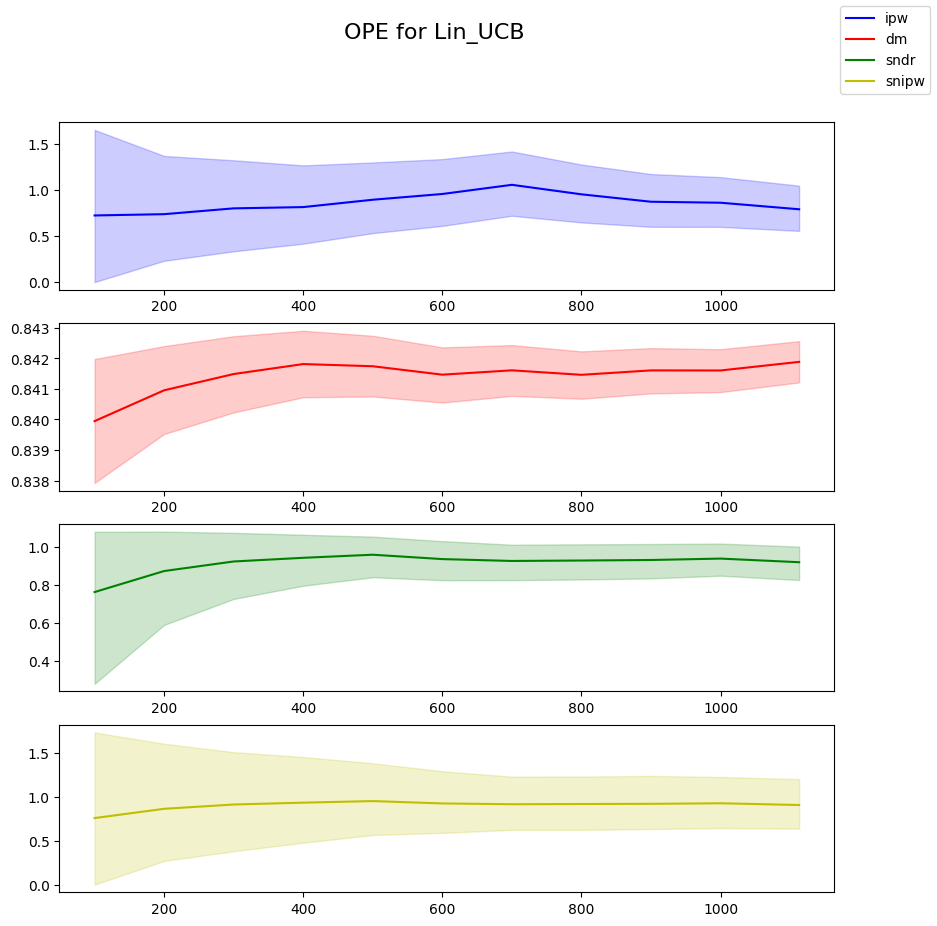

In [27]:
plot_disjoint_res(Vs_2, CIs_2, 'Lin_UCB')

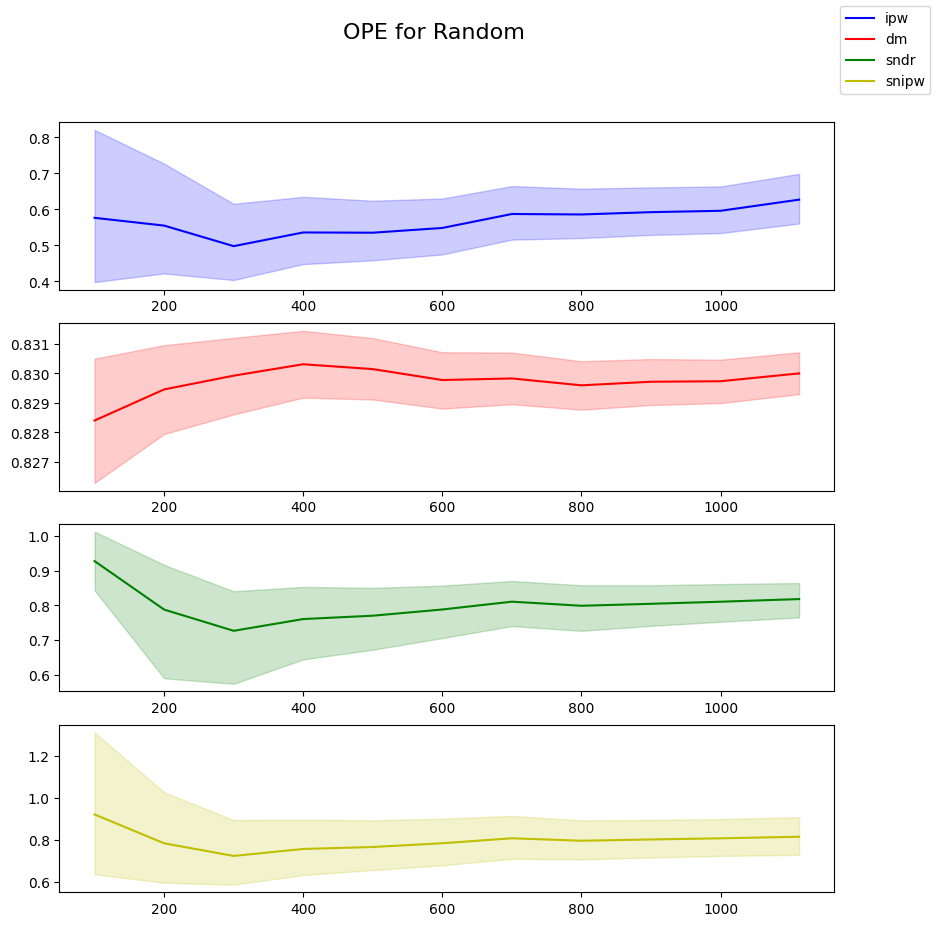

In [28]:
plot_disjoint_res(Vs_3, CIs_3, 'Random')

In [29]:
out_str = f"Scores for UCB true"
for key, val in Vs_1[-1].items():
    out_str += f" {key} : {(1e3 * val):.3f},"
out_str = out_str[:-1]
print(out_str)

Scores for UCB true ipw : 458.164, dm : 829.192, sndr : 782.167, snipw : 779.218


In [30]:
out_str = f"Scores for Lin_UCB true"
for key, val in Vs_2[-1].items():
    out_str += f" {key} : {(1e3 * val):.3f},"
out_str = out_str[:-1]
print(out_str)

Scores for Lin_UCB true ipw : 791.648, dm : 841.881, sndr : 920.750, snipw : 908.198


In [31]:
out_str = f"Scores for random true"
for key, val in Vs_3[-1].items():
    out_str += f" {key} : {(1e3 * val):.3f},"
out_str = out_str[:-1]
print(out_str)

Scores for random true ipw : 627.394, dm : 829.998, sndr : 817.994, snipw : 815.213


In [32]:
print("USB all")
print(Vs_1)

USB all
[{'ipw': 0.3684966490901707, 'dm': 0.82758878642268, 'sndr': 0.9406286011033451, 'snipw': 0.9364057682918135}, {'ipw': 0.3906445336120644, 'dm': 0.8286563185794518, 'sndr': 0.6150050850610927, 'snipw': 0.6100104789237052}, {'ipw': 0.3329144101354423, 'dm': 0.8291135041610334, 'sndr': 0.5990979801050836, 'snipw': 0.5948052927401571}, {'ipw': 0.35319594250787284, 'dm': 0.8295074347399133, 'sndr': 0.6531924255253329, 'snipw': 0.6486659705329657}, {'ipw': 0.34947740926591103, 'dm': 0.8293434123535837, 'sndr': 0.680200346299046, 'snipw': 0.675767545732862}, {'ipw': 0.36350594893264876, 'dm': 0.8289681784653995, 'sndr': 0.7147386314072001, 'snipw': 0.7107408263627307}, {'ipw': 0.3902782670098366, 'dm': 0.8290225580063261, 'sndr': 0.7492552881308074, 'snipw': 0.7465605817911125}, {'ipw': 0.3900637325090961, 'dm': 0.8287854746681151, 'sndr': 0.7237888741702848, 'snipw': 0.721326450692205}, {'ipw': 0.39521756637842753, 'dm': 0.8289068222827642, 'sndr': 0.7390990108784046, 'snipw': 0.736

In [33]:
print("Lin USB all")
print(Vs_2)

Lin USB all
[{'ipw': 0.7209298093002079, 'dm': 0.8399444761740074, 'sndr': 0.7613570092259514, 'snipw': 0.7556918916163586}, {'ipw': 0.7371031654641175, 'dm': 0.8409607574174557, 'sndr': 0.8732416604478204, 'snipw': 0.8634843881298795}, {'ipw': 0.7992779493817301, 'dm': 0.8414832880509455, 'sndr': 0.9241378536950449, 'snipw': 0.9114107244700181}, {'ipw': 0.8137252121779914, 'dm': 0.8418150442477733, 'sndr': 0.9437090489810387, 'snipw': 0.9331789533793428}, {'ipw': 0.8929861496722639, 'dm': 0.8417445324275802, 'sndr': 0.9599041651076085, 'snipw': 0.9503895651267777}, {'ipw': 0.9576325787618126, 'dm': 0.8414639792076909, 'sndr': 0.9371521774819733, 'snipw': 0.9259755351150466}, {'ipw': 1.0562669513001604, 'dm': 0.8416062548555554, 'sndr': 0.9269214809693312, 'snipw': 0.9158961704515962}, {'ipw': 0.9527790086435624, 'dm': 0.8414566493757577, 'sndr': 0.9292439043429763, 'snipw': 0.9182098439275908}, {'ipw': 0.8724048070974334, 'dm': 0.8416006412638091, 'sndr': 0.9320301658307873, 'snipw': 

In [34]:
print("Random all")
print(Vs_3)

Random all
[{'ipw': 0.5772802247523167, 'dm': 0.8284014241986849, 'sndr': 0.9274079476588158, 'snipw': 0.9221395074733146}, {'ipw': 0.5556874970314517, 'dm': 0.8294649375191172, 'sndr': 0.7887940419491761, 'snipw': 0.7844722501349195}, {'ipw': 0.4973670174562157, 'dm': 0.8299203324514864, 'sndr': 0.7262266464260667, 'snipw': 0.7224817302476129}, {'ipw': 0.5353981618012638, 'dm': 0.8303127766763804, 'sndr': 0.7599984203002396, 'snipw': 0.755748161069213}, {'ipw': 0.5351005601173675, 'dm': 0.8301493376473312, 'sndr': 0.7699727479825083, 'snipw': 0.7656572425014774}, {'ipw': 0.5484085975102648, 'dm': 0.8297755090712965, 'sndr': 0.7876455265625272, 'snipw': 0.783722344964383}, {'ipw': 0.587086013876196, 'dm': 0.8298297005076906, 'sndr': 0.8101339851262199, 'snipw': 0.8072052560461007}, {'ipw': 0.5859684175879635, 'dm': 0.8295934977129735, 'sndr': 0.7984660270977452, 'snipw': 0.7957149839463318}, {'ipw': 0.5922337878325235, 'dm': 0.8297143659531099, 'sndr': 0.8041688048372168, 'snipw': 0.80

In [35]:
print("Estimated confidence intervals UCB:")
print(pd.DataFrame(CIs_1[-1]).to_string())
print("Estimated confidence intervals Lin UCB:")
print(pd.DataFrame(CIs_2[-1]).to_string())
print("Estimated confidence intervals Random:")
print(pd.DataFrame(CIs_3[-1]).to_string())

Estimated confidence intervals UCB:
                       ipw        dm      sndr     snipw
mean              0.458156  0.829193  0.782294  0.779204
95.0% CI (lower)  0.377812  0.828487  0.641080  0.642560
95.0% CI (upper)  0.558623  0.829909  0.880953  0.950073
Estimated confidence intervals Lin UCB:
                       ipw        dm      sndr     snipw
mean              0.789352  0.841882  0.920328  0.905564
95.0% CI (lower)  0.555029  0.841209  0.826155  0.636743
95.0% CI (upper)  1.045571  0.842559  1.002835  1.199504
Estimated confidence intervals Random:
                       ipw        dm      sndr     snipw
mean              0.627196  0.829999  0.817891  0.814956
95.0% CI (lower)  0.560890  0.829296  0.765011  0.728801
95.0% CI (upper)  0.698833  0.830713  0.864162  0.908038
